# Préparation du dataset v2

Ce dataset aura les meme colonnes que le dataset original, mais les colonnes catégorielles seront transformées en numériques et les colonnes avec trop de valeurs manquantes seront supprimées.

In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import os
# ajout du chemin src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path: sys.path.append(project_root)
from src.data_prep import load_and_feature_engineering, reduce_mem_usage, missing_values_table

In [2]:
# Cela appelle notre fonction .py qui fait les ratios + les jointures
df = load_and_feature_engineering()

Base Train chargée: (307511, 122)
Après get_bureau_features: (307511, 139)
Après get_previous_features: (307511, 142)
Après get_pos_cash_features: (307511, 145)
Après get_installments_features: (307511, 156)
Après get_credit_card_features: (307511, 159)
--- Terminé ---


In [3]:
# On enleve tout ce qui concerne l'habitat c'est les colonnes avec AVG, MODE, MEDI 
cols_to_drop = [c for c in df.columns if '_AVG' in c or '_MODE' in c or '_MEDI' in c]
# On enleve les FLAG_DOCUMENT 
cols_to_drop.extend([c for c in df.columns if 'FLAG_DOCUMENT' in c])
# On enleve les infos de contact social inutiles
cols_to_drop.extend(['FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE'])

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Correction Outliers (Revenu et Jours travaillés) 
df = df[df['AMT_INCOME_TOTAL'] < 100000000] # Vire le 117M
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)
# en gros le days employed se fait a partir du jours ou on a demandé le pret donc si c'est positif c'est que c'est dans le futur donc on vire aussi.
df.shape

(307510, 92)

In [4]:
# reduction de la taille en memoire
df = reduce_mem_usage(df)

Usage mémoire initial du DataFrame: 218.19 MB
Usage mémoire final du DataFrame: 82.41 MB
Mémoire réduite de 62.2 %


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Définition des listes de colonnes
LABEL_ENCODE_COLS = ['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
GET_DUMMIES_COLS = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START']

# Application du Label Encoding
le = LabelEncoder()
for col in LABEL_ENCODE_COLS:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('Missing')
        df[col] = le.fit_transform(df[col])

# Application du Get Dummies (One-Hot Encoding)
df = pd.get_dummies(df, columns=GET_DUMMIES_COLS, dummy_na=False)

In [6]:
# Gestion des caractères spéciaux dans les noms de colonnes (pour LightGBM)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
df.shape

(307510, 126)

Analyse santé du dataset

1. Check Infinis : 0 valeurs infinies détectées

2. Top 10 des colonnes vides (%)
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN    80.117720
CC_AMT_BALANCE_MEAN                 71.739130
CC_SK_DPD_MAX                       71.739130
OWN_CAR_AGE                         65.990699
EXT_SOURCE_PROD                     64.362785
EXT_SOURCE_1                        56.381256
EXT_SOURCE_1_x_DAYS_BIRTH           56.381256
EXT_SOURCE_3                        19.825372
DAYS_EMPLOYED                       18.007219
BUREAU_AMT_CREDIT_SUM_DEBT_MEAN     16.708400
dtype: float64

3. Vérification des Outliers Métier
Revenu Max : 18,000,090
Jours Travaillés Max (devrait être <= 0) : 0.0


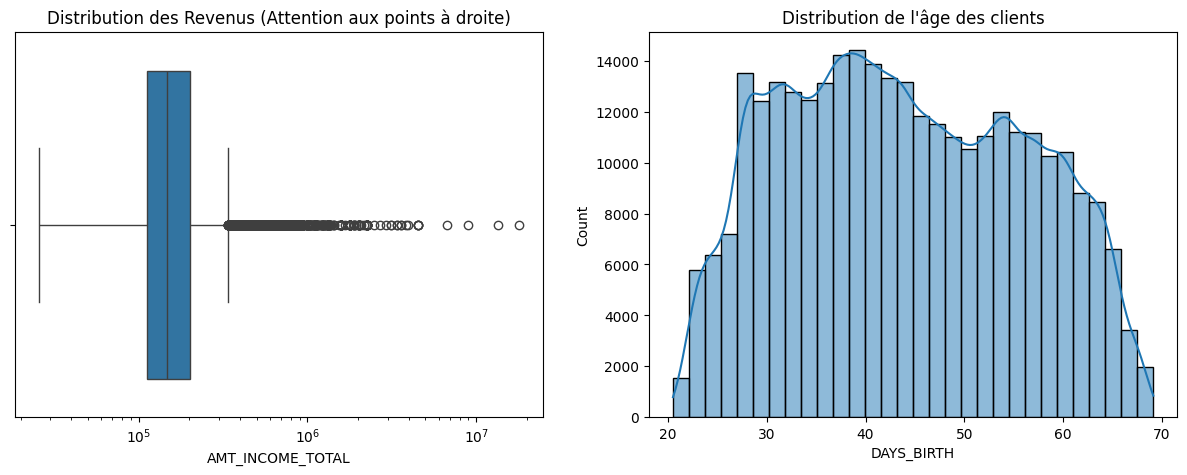

In [ ]:
# Vérification des Infinis : si on divise par 0, ça crée 'inf'
numeric_cols = df.select_dtypes(include=[np.number]).columns # On ne regarde que les colonnes numériques
inf_count = np.isinf(df[numeric_cols]).sum().sum()

print(f"1. Check Infinis : {inf_count} valeurs infinies détectées")
if inf_count > 0:
    # Affiche les colonnes coupables
    cols_with_inf = [col for col in numeric_cols if np.isinf(df[col]).sum() > 0]
    print(f"Colonnes concernées : {cols_with_inf}")

    df.replace([np.inf, -np.inf], np.nan, inplace=True) # on remplace inf par NaN
    print("Correction appliquée : inf -> NaN")

# Vérification des Valeurs Manquantes (Top 10)
print("\n2. Top 10 des colonnes vides (%)")
missing_perc = (df.isnull().sum() / len(df)) * 100
print(missing_perc.sort_values(ascending=False).head(10))

print("\n3. Vérification des Outliers Métier")
print(f"Revenu Max : {df['AMT_INCOME_TOTAL'].max():,.0f}") # Revenus

if df['AMT_INCOME_TOTAL'].max() > 20000000:
    print("ALERTE : Il y a des revenus > 20 Millions. À vérifier !")

# Jours Travaillés (Le bug des 1000 ans, soit 365243 jours)
print(f"Jours Travaillés Max (devrait être <= 0) : {df['DAYS_EMPLOYED'].max()}")

# Visualisation Boxplot
plt.figure(figsize=(15, 5))
# Distribution des Revenus (Log scale pour mieux voir)
plt.subplot(1, 2, 1)
sns.boxplot(x=df['AMT_INCOME_TOTAL'])
plt.title('Distribution des Revenus (Attention aux points à droite)')
plt.xscale('log') # On met en log car les écarts sont énormes

# Distribution de l'âge (en années)
plt.subplot(1, 2, 2)
sns.histplot(df['DAYS_BIRTH'] / -365, bins=30, kde=True)
plt.title("Distribution de l'âge des clients")

plt.show()

Ici les colonnes vide sont importante, elles nous donnent des informations sur les clients. 

In [8]:
y = df['TARGET']
X = df.drop(columns=['TARGET','SK_ID_CURR'])
print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (307510, 124)
Shape y: (307510,)


In [ ]:
# Analyse du dataset final 
print(f"Dataset final : {X.shape[0]:,} lignes et {X.shape[1]:,} colonnes.")

Dataset final : 307,510 lignes et 124 colonnes.


In [ ]:
# On sauvegarde en format Pickle (plus rapide que CSV et garde les types de données)
X.to_pickle('../data/processed/X_prepared_v2.pkl')
y.to_pickle('../data/processed/y_prepared_v2.pkl')